# Model free analysis in the Aging project

1. In this notebook I will look at catch trial fails <br>
2. Age effect on proportion <br>
    2.1 age effect on proportion in risky trials <br>
    2.2 age effect on proportion in ambiguous trials <br>
3. cross domain correlations <br> 
4. consistency 

## Load libraries 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Load data

In [2]:
db_mon = pd.read_csv('data/mon.csv')
db_med = pd.read_csv('data/med.csv')

print('Participants monetary: ', len(db_mon['sub'].unique()), 'participants medical: ', len(db_med['sub'].unique()))

Participants monetary:  84 participants medical:  84


In [3]:
risk_min = 2 # the minimum number of trials participant chose the lottery.

# collect number of lottery selection by subject
choices_mon = db_mon[['sub','choice']].groupby(['sub']).sum()
choices_med = db_med[['sub','choice']].groupby(['sub']).sum()

# get the subject number for participant who were too risk averse
too_risk_averse_mon = list(choices_mon[choices_mon['choice']<risk_min].index)
too_risk_averse_med = list(choices_med[choices_med['choice']<risk_min].index)

print('Monetary too risk averse (', risk_min, '): ', too_risk_averse_mon)
print('Medical too risk averse (', risk_min, '): ', too_risk_averse_med)


# remove too risk averse particiants from the files
db_mon = db_mon[~db_mon['sub'].isin(too_risk_averse_mon)]
db_med = db_med[~db_med['sub'].isin(too_risk_averse_med)]

# compare monetary and medical lists and keep only valid participants in both
mon_s = list(db_mon['sub'].unique())
med_s = list(db_med['sub'].unique())

db_mon = db_mon[db_mon['sub'].isin(med_s)]
db_med = db_med[db_med['sub'].isin(mon_s)]

print('Final sample of participants with R&A data: ', len(db_med['sub'].unique()))


Monetary too risk averse ( 2 ):  [11, 40, 65]
Medical too risk averse ( 2 ):  [65]
Final sample of participants with R&A data:  81


In [4]:
#Load Age and MoCA scores from the session log file.
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='sessions').iloc[:,[0,7,9]]
moca = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='assessments').iloc[:,[0,22]]

# Change name of the first column to 'sub'
age.columns.values[0] = moca.columns.values[0] = "sub"

# remove unnecessary rows
age = age[age.gender != 'gender']
age = age.dropna().reset_index()
age = age.drop(['index'], axis=1)

print("Number of participants with age: ",age.shape[0])
# merge files
age = age.merge(moca, left_on='sub', right_on='sub')
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_'))) # remove the AG_ prfix from the subject number
age['sub'] = age['sub'].astype(int)
age['age'] = age.age.astype('int')

print('Number of participants with MoCA: ', age.shape[0], '; MoCA > 25:', age[age.moca_score>25].shape[0])

Number of participants with age:  87
Number of participants with MoCA:  75 ; MoCA > 25: 57


## Remove participants with missing data

Remove all participants with no MoCA

In [5]:
# make a list with subjects number
s_am = list(age['sub'].unique())
s_ra = list(db_mon['sub'].unique())

# find participant in one list but not in the second
demo_no_ra = list(set(s_am)- set(s_ra))
ra_no_demo = list(set(set(s_ra)- set(s_am)))

print ('pariticpant with R&A and no MoCA:', ra_no_demo)
print ('pariticpant with MoCA and no R&A:', demo_no_ra)

age = age[age['sub'].isin(db_mon['sub'].values)]

# remove participants without age/moca from the db and add age, moca and gender
db_mon = db_mon.merge(age, left_on='sub', right_on='sub')
db_med = db_med.merge(age, left_on='sub', right_on='sub')

print('Number of participants with all data:', len(db_med['sub'].unique()))

pariticpant with R&A and no MoCA: [34, 98, 99, 100, 102, 12, 81, 84, 21, 95]
pariticpant with MoCA and no R&A: [40, 65, 11, 28]
Number of participants with all data: 71


<AxesSubplot:xlabel='age', ylabel='Count'>

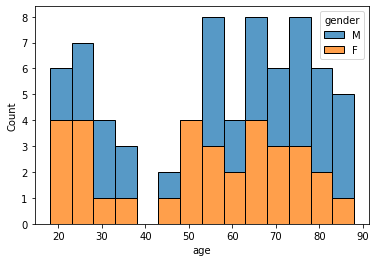

In [6]:
sns.histplot(x='age', hue='gender', data=age, multiple="stack", binwidth=5)

Participants with MoCA>25


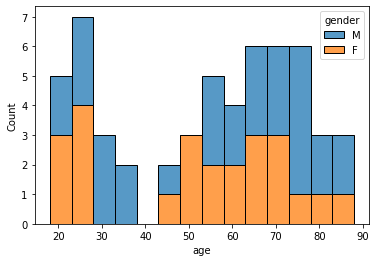

In [7]:
sns.histplot(x='age', hue='gender', data=age[age['moca_score']>25], multiple="stack", binwidth=5)
print('Participants with MoCA>25')

## Missed trials by age

In [8]:
# average number of times participants chose the lottery in catch trials
catch_mon = pd.DataFrame(db_mon[db_mon.value==5].groupby('sub').mean()['choice'])
catch_med = pd.DataFrame(db_med[db_med.value==5].groupby('sub').mean()['choice'])

# merge data sets
catch = catch_mon.merge(catch_med, left_on='sub', right_on='sub')

# create a mean catch across trials
catch['choice'] = (catch.choice_x +  catch.choice_y)/2

catch.columns = ['Montary', 'Medical', 'OverAll']

# add age and MoCA
catch = catch.merge(age, left_on='sub', right_on='sub')

Text(20, 0.9, 'r = 0.22, p = 0.06')

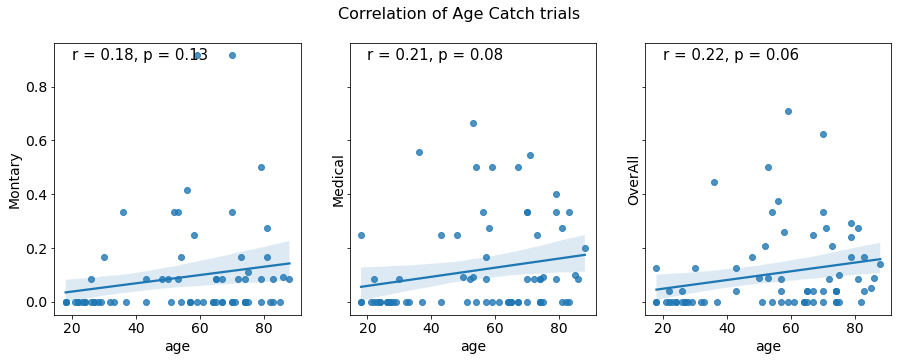

In [9]:
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)
f.suptitle('Correlation of Age Catch trials', fontsize=16)


sns.regplot(x = 'age', y = 'Montary', data = catch, ax=ax[0])
sns.regplot(x = 'age', y = 'Medical', data = catch, ax=ax[1])
sns.regplot(x = 'age', y = 'OverAll', data = catch, ax=ax[2])


corr = (sp.stats.pearsonr(catch.age, catch.Montary))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0].text(20, .9, text, fontsize=15)

corr = (sp.stats.pearsonr(catch.age, catch.Medical))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1].text(20, .9, text, fontsize=15)

corr = (sp.stats.pearsonr(catch.age, catch.OverAll))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[2].text(20, .9, text, fontsize=15)

Text(20, 0.9, 'r = -0.27, p = 0.02')

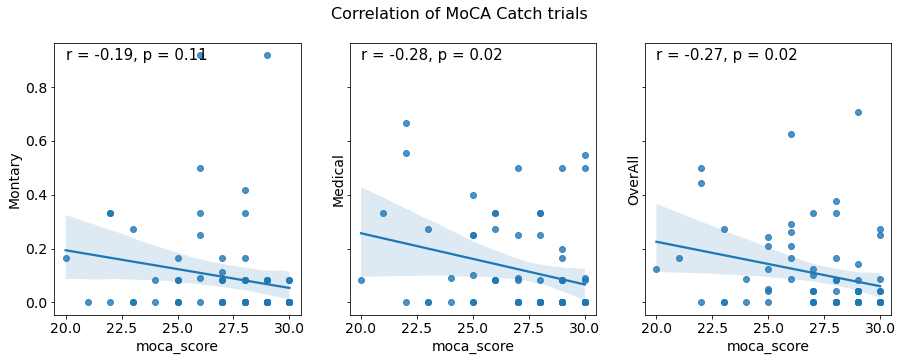

In [10]:
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)
f.suptitle('Correlation of MoCA Catch trials', fontsize=16)

sns.regplot(x = 'moca_score', y = 'Montary', data = catch, ax=ax[0])
sns.regplot(x = 'moca_score', y = 'Medical', data = catch, ax=ax[1])
sns.regplot(x = 'moca_score', y = 'OverAll', data = catch, ax=ax[2])

corr = (sp.stats.pearsonr(catch.moca_score, catch.Montary))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0].text(20, .9, text, fontsize=15)

corr = (sp.stats.pearsonr(catch.moca_score, catch.Medical))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1].text(20, .9, text, fontsize=15)

corr = (sp.stats.pearsonr(catch.moca_score, catch.OverAll))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[2].text(20, .9, text, fontsize=15)

### drop low MoCA and catch fails

Text(20, 0.5, 'r = 0.37, p = 0.01')

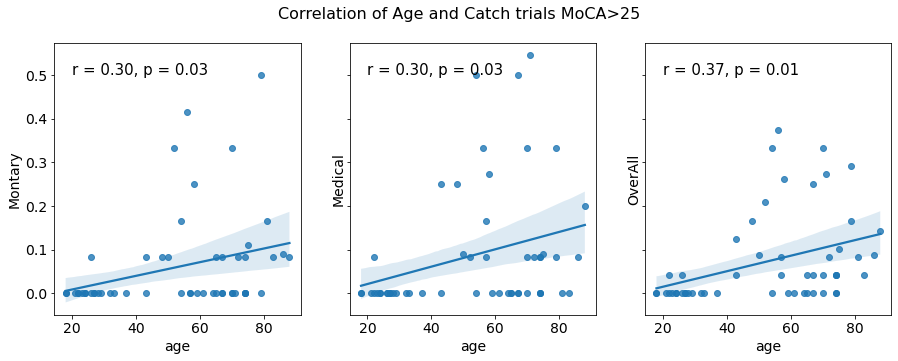

In [11]:
catch_moca = catch[catch['OverAll']<0.5]
catch_fails = list(set(catch['sub']) - set(catch_moca['sub']))
catch_stay = catch_moca['sub'].values
catch_moca = catch_moca[catch_moca['moca_score']>25]


plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)
f.suptitle('Correlation of Age and Catch trials MoCA>25', fontsize=16)


sns.regplot(x = 'age', y = 'Montary', data = catch_moca, ax=ax[0])
sns.regplot(x = 'age', y = 'Medical', data = catch_moca, ax=ax[1])
sns.regplot(x = 'age', y = 'OverAll', data = catch_moca, ax=ax[2])


corr = (sp.stats.pearsonr(catch_moca.age, catch_moca.Montary))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0].text(20, .5, text, fontsize=15)

corr = (sp.stats.pearsonr(catch_moca.age, catch_moca.Medical))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1].text(20, .5, text, fontsize=15)

corr = (sp.stats.pearsonr(catch_moca.age, catch_moca.OverAll))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[2].text(20, .5, text, fontsize=15)

In [12]:
len(catch_stay)

68

In [13]:
# participants who failed in catach trials
print('participant who failed more than half the catch trials in both tasks:', catch_fails)

# remove participant who failed the attention check (catch trials)
db_mon = db_mon[db_mon['sub'].isin(catch_stay)]
print('participant who passed attention check:', len(db_mon['sub'].unique()))

participant who failed more than half the catch trials in both tasks: [17, 27, 22]
participant who passed attention check: 68


## Proportion analysis

In [14]:
mon_prop = db_mon.groupby('sub').mean()
med_prop = db_med.groupby('sub').mean()

Text(20, 0.9, 'r = -0.10, p = 0.40')

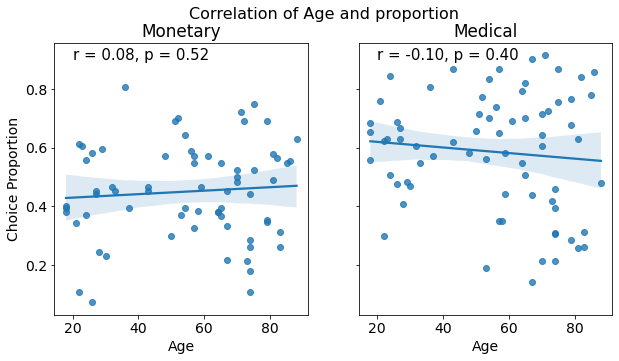

In [15]:
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True)
f.suptitle('Correlation of Age and proportion', fontsize=16)

sns.regplot(x = 'age', y = 'choice', data = mon_prop, ax=ax[0])
sns.regplot(x = 'age', y = 'choice', data = med_prop, ax=ax[1])


ax[0].set(xlabel='Age', ylabel='Choice Proportion', title='Monetary')
ax[1].set(xlabel='Age', ylabel=None, title='Medical')

corr = (sp.stats.pearsonr(mon_prop.age, mon_prop.choice))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0].text(20, .9, text, fontsize=15)

corr = (sp.stats.pearsonr(med_prop.age, med_prop.choice))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1].text(20, .9, text, fontsize=15)

Text(20, 0.9, 'r = -0.13, p = 0.34')

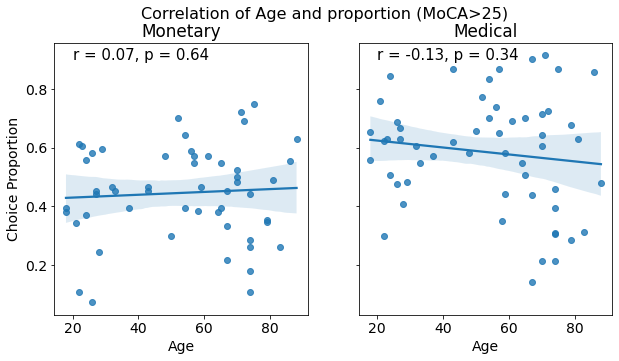

In [16]:
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True)
f.suptitle('Correlation of Age and proportion (MoCA>25)', fontsize=16)

sns.regplot(x = 'age', y = 'choice', data = mon_prop[mon_prop['moca_score']>25], ax=ax[0])
sns.regplot(x = 'age', y = 'choice', data = med_prop[med_prop['moca_score']>25], ax=ax[1])


ax[0].set(xlabel='Age', ylabel='Choice Proportion', title='Monetary')
ax[1].set(xlabel='Age', ylabel=None, title='Medical')

corr = (sp.stats.pearsonr(mon_prop[mon_prop['moca_score']>25].age, mon_prop[mon_prop['moca_score']>25].choice))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0].text(20, .9, text, fontsize=15)

corr = (sp.stats.pearsonr(med_prop[med_prop['moca_score']>25].age, med_prop[med_prop['moca_score']>25].choice))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1].text(20, .9, text, fontsize=15)

In [17]:
# subset the datasets to be able to plot choice proportion based on value and risk/ambiguity preference
mon_risk = db_mon[db_mon['ambiguity'] == 0]
mon_amb  = db_mon[db_mon['ambiguity'] >  0]

med_risk = db_med[db_med['ambiguity'] == 0]
med_amb  = db_med[db_med['ambiguity'] >  0]

In [18]:
# get participants response at 0.5 risk and no ambiguity for ambiguity corrections
amb_correction_mon = db_mon[(db_mon['ambiguity'] == 0) & (db_mon['risk'] == 0.5)][['sub','value','choice']]
amb_correction_mon = amb_correction_mon.groupby(['sub','value']).mean()
amb_correction_mon.reset_index(inplace=True)

amb_correction_med = db_med[(db_med['ambiguity'] == 0) & (db_med['risk'] == 0.5)][['sub','value','choice']]
amb_correction_med = amb_correction_med.groupby(['sub','value']).mean()
amb_correction_med.reset_index(inplace=True)

In [19]:
mon_prop_r = mon_risk.groupby(['sub','value']).mean()
mon_prop_a = mon_amb.groupby(['sub','value']).mean()
med_prop_r = med_risk.groupby(['sub','value']).mean()
med_prop_a = med_amb.groupby(['sub','value']).mean()

mon_prop_unc_r = mon_risk.groupby(['sub','risk']).mean()
mon_prop_unc_a = mon_amb.groupby(['sub','ambiguity']).mean()
med_prop_unc_r = med_risk.groupby(['sub','risk']).mean()
med_prop_unc_a = med_amb.groupby(['sub','ambiguity']).mean()


mon_prop_r.reset_index(inplace=True)
mon_prop_a.reset_index(inplace=True)
med_prop_r.reset_index(inplace=True)
med_prop_a.reset_index(inplace=True)

mon_prop_unc_r.reset_index(inplace=True)
mon_prop_unc_a.reset_index(inplace=True)
med_prop_unc_r.reset_index(inplace=True)
med_prop_unc_a.reset_index(inplace=True)

In [20]:
# correct ambiguity for risk preferance at 0.5
mon_prop_a['choice']=mon_prop_a['choice']-amb_correction_mon['choice']
med_prop_a['choice']=med_prop_a['choice']-amb_correction_med['choice']
mon_prop_unc_a['choice']=mon_prop_unc_a['choice']-amb_correction_mon['choice']
med_prop_unc_a['choice']=med_prop_unc_a['choice']-amb_correction_mon['choice']

In [21]:
norm = matplotlib.colors.Normalize(vmin=18, vmax=90)
colors = {}
cmap = sns.diverging_palette(240, 10, as_cmap=True )

for cval in range(18,90):
    colors.update({cval : cmap(norm(cval))})
    

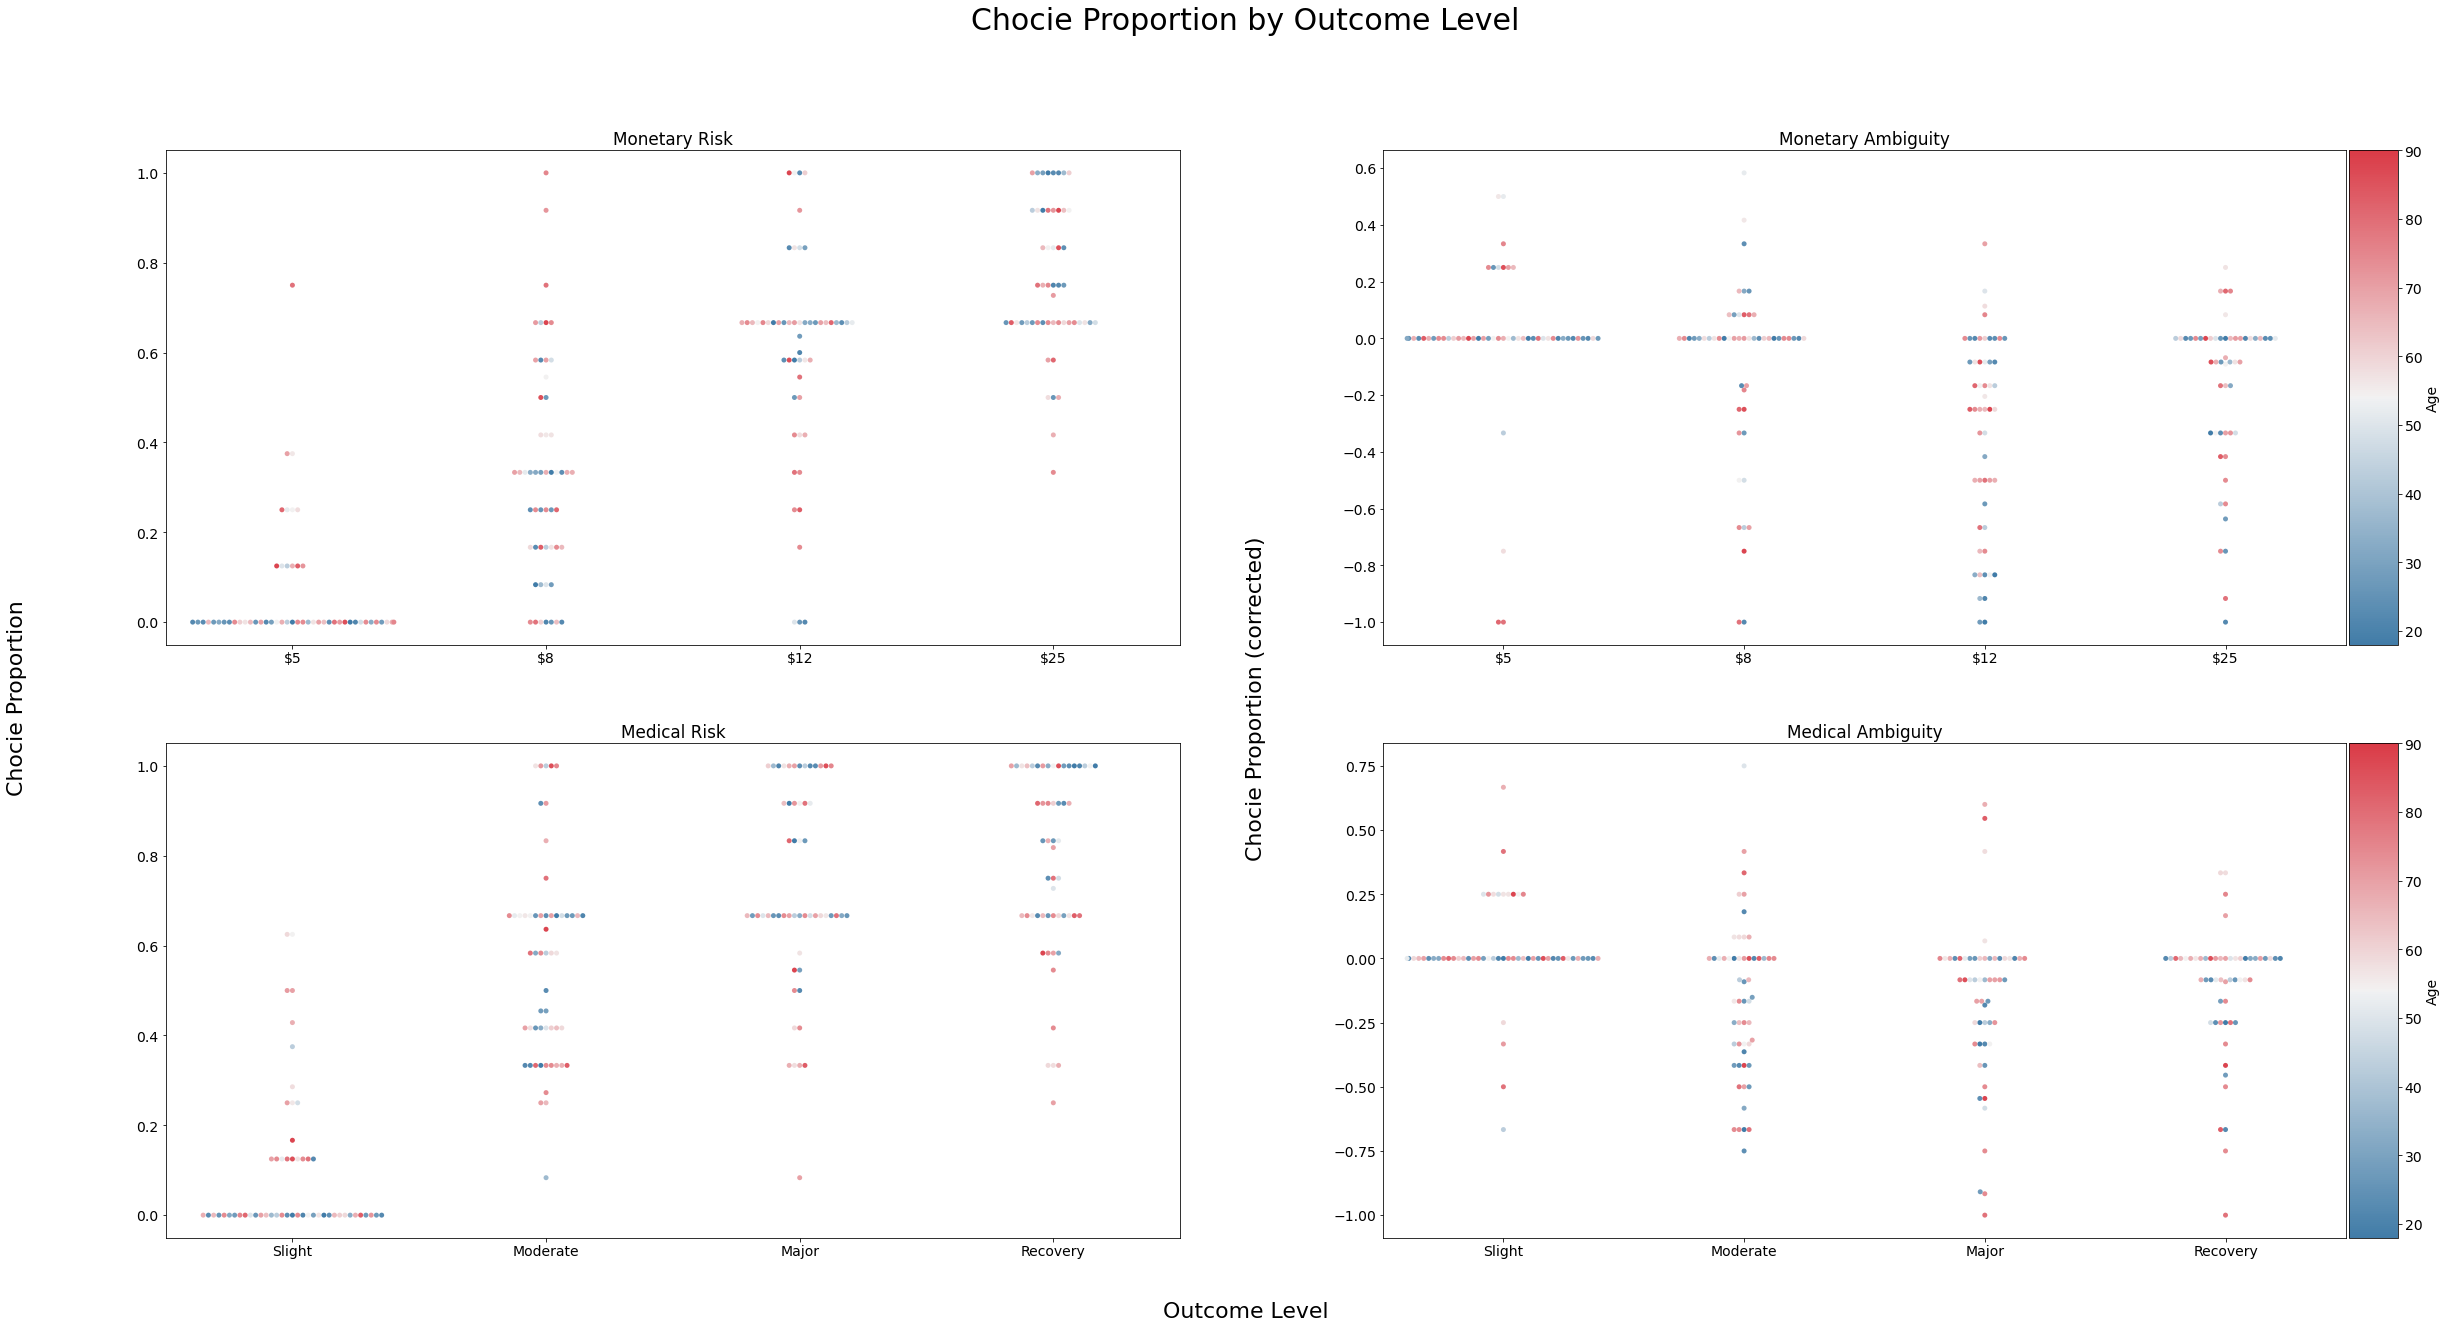

In [22]:
#plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize = (40,20))
fig.suptitle('Chocie Proportion by Outcome Level', fontsize=30)

fig.text(0.5, 0.07, 'Outcome Level', ha='center', fontsize=22)
fig.text(0.07, 0.5, 'Chocie Proportion', va='center', rotation='vertical', fontsize=22)
fig.text(0.5, 0.5, 'Chocie Proportion (corrected)', va='center', rotation='vertical', fontsize=22)

ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222) 

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')

ax3 = fig.add_subplot(223)  
ax4 = fig.add_subplot(224)  

sns.swarmplot(x = 'value', y = 'choice', data = mon_prop_r[mon_prop_r['moca_score']>25] , ax = ax1, hue = 'age', palette = colors)
sns.swarmplot(x = 'value', y = 'choice', data = mon_prop_a[mon_prop_a['moca_score']>25] , ax = ax2, hue = 'age', palette = colors)
sns.swarmplot(x = 'value', y = 'choice', data = med_prop_r[med_prop_r['moca_score']>25] , ax = ax3, hue = 'age', palette = colors)
sns.swarmplot(x = 'value', y = 'choice', data = med_prop_a[med_prop_a['moca_score']>25] , ax = ax4, hue = 'age', palette = colors)

ax1.set(xlabel=None, ylabel=None, xticklabels=['$5','$8','$12','$25'], title='Monetary Risk')
ax2.set(xlabel=None, ylabel=None, xticklabels=['$5','$8','$12','$25'], title='Monetary Ambiguity')
ax3.set(xlabel=None, ylabel=None, xticklabels=['Slight','Moderate','Major','Recovery'], title='Medical Risk')
ax4.set(xlabel=None, ylabel=None, xticklabels=['Slight','Moderate','Major','Recovery'], title='Medical Ambiguity')

ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()
ax4.legend_.remove()
    
## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()

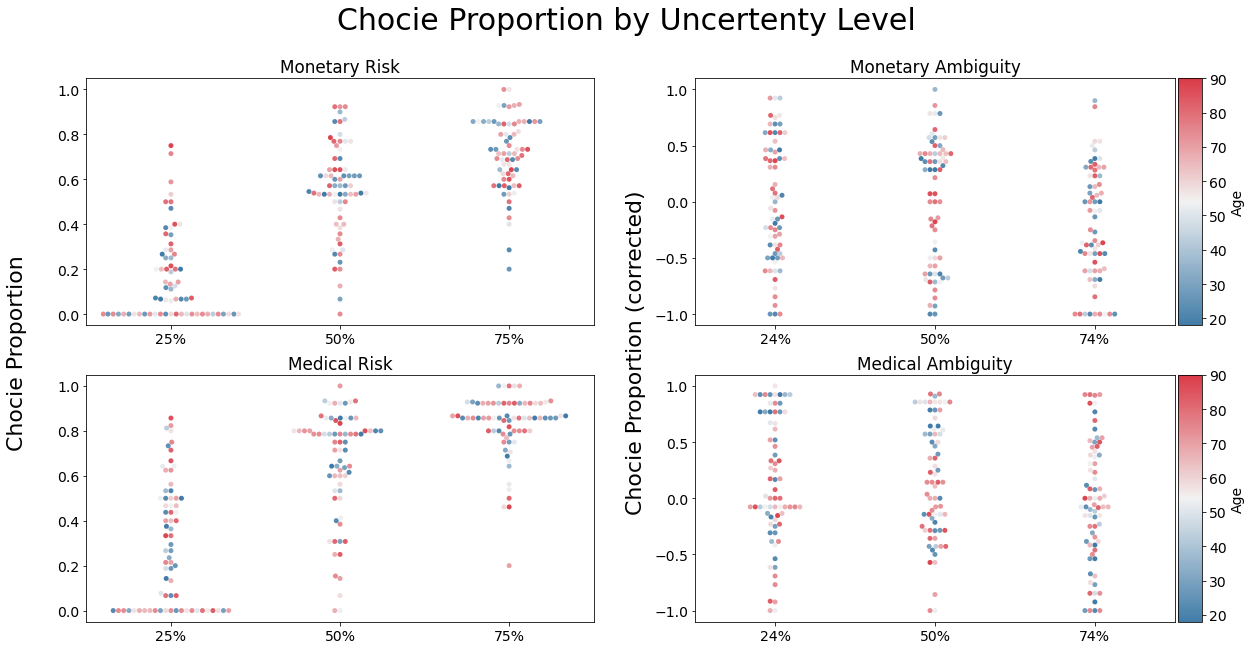

In [23]:
fig = plt.figure(figsize = (20,10))
fig.suptitle('Chocie Proportion by Uncertenty Level', fontsize=30)

# fig.text(0.5, 0.07, 'Outcome Level', ha='center', fontsize=22)
fig.text(0.07, 0.5, 'Chocie Proportion', va='center', rotation='vertical', fontsize=22)
fig.text(0.5, 0.5, 'Chocie Proportion (corrected)', va='center', rotation='vertical', fontsize=22)


ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)  

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')

ax3 = fig.add_subplot(223)  
ax4 = fig.add_subplot(224)  

sns.swarmplot(x = 'risk',      y = 'choice', data = mon_prop_unc_r , ax = ax1, hue = 'age', palette = colors)
sns.swarmplot(x = 'ambiguity', y = 'choice', data = mon_prop_unc_a , ax = ax2, hue = 'age', palette = colors)
sns.swarmplot(x = 'risk',      y = 'choice', data = med_prop_unc_r , ax = ax3, hue = 'age', palette = colors)
sns.swarmplot(x = 'ambiguity', y = 'choice', data = med_prop_unc_a , ax = ax4, hue = 'age', palette = colors)

ax1.set(xlabel=None, ylabel=None, xticklabels=['25%','50%','75%'], title='Monetary Risk')
ax2.set(xlabel=None, ylabel=None, xticklabels=['24%','50%','74%'], title='Monetary Ambiguity')
ax3.set(xlabel=None, ylabel=None, xticklabels=['25%','50%','75%'], title='Medical Risk')
ax4.set(xlabel=None, ylabel=None, xticklabels=['24%','50%','74%'], title='Medical Ambiguity')

ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()
ax4.legend_.remove()
    
## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()


In [24]:
mon_risk_prop = db_mon[(db_mon.choice == 1) & (db_mon.ambiguity == 0)].groupby('sub').count()['choice']/db_mon[(db_mon.ambiguity == 0)].groupby('sub').count()['choice']
mon_ambg_prop = db_mon[(db_mon.choice == 1) & (db_mon.ambiguity >  0)].groupby('sub').count()['choice']/db_mon[(db_mon.ambiguity >  0)].groupby('sub').count()['choice']

med_risk_prop = db_med[(db_med.choice == 1) & (db_med.ambiguity == 0)].groupby('sub').count()['choice']/db_med[(db_med.ambiguity == 0)].groupby('sub').count()['choice']
med_ambg_prop = db_med[(db_med.choice == 1) & (db_med.ambiguity >  0)].groupby('sub').count()['choice']/db_med[(db_med.ambiguity >  0)].groupby('sub').count()['choice']

mon_risk_prop = mon_risk_prop.replace(np.nan, 0)
mon_ambg_prop = mon_ambg_prop.replace(np.nan, 0)
med_risk_prop = med_risk_prop.replace(np.nan, 0)
med_ambg_prop = med_ambg_prop.replace(np.nan, 0)

mon_risk_prop=mon_risk_prop.reset_index()
mon_ambg_prop=mon_ambg_prop.reset_index()
med_risk_prop=med_risk_prop.reset_index()
med_ambg_prop=med_ambg_prop.reset_index()

In [25]:
mon_ambg_prop = mon_ambg_prop.merge(amb_correction_mon.groupby('sub').mean(), left_on='sub', right_on='sub')
med_ambg_prop = med_ambg_prop.merge(amb_correction_med.groupby('sub').mean(), left_on='sub', right_on='sub')

mon_ambg_prop['choice'] = mon_ambg_prop.choice_x-mon_ambg_prop.choice_y
med_ambg_prop['choice'] = med_ambg_prop.choice_x-med_ambg_prop.choice_y

In [26]:
proportion = mon_risk_prop.merge(med_risk_prop, left_on='sub', right_on='sub')

proportion = proportion.merge(mon_ambg_prop[['sub','choice']], left_on='sub', right_on='sub')
proportion = proportion.merge(med_ambg_prop[['sub','choice']], left_on='sub', right_on='sub')

proportion.columns = ['sub', 'MontaryRisk', 'MedicalRisk', 'MontaryAmb', 'MedicalAmb']
proportion = proportion.merge(age, left_on='sub', right_on='sub')

proportion = proportion[proportion.moca_score>25]

In [28]:
corRisk = sp.stats.pearsonr(proportion.MontaryRisk, proportion.MedicalRisk)
corAmb = sp.stats.pearsonr(proportion.MontaryAmb, proportion.MedicalAmb)
corMon = sp.stats.pearsonr(proportion.MontaryRisk, proportion.MontaryAmb)
corMed = sp.stats.pearsonr(proportion.MedicalRisk, proportion.MedicalAmb)

print('corRisk:', corRisk, '\ncorAmb: ', corAmb, '\ncorMon: ', corMon, '\ncorMed: ', corMed)

corRisk: (0.440121065474826, 0.0009744509905267492) 
corAmb:  (0.6375209178620068, 2.8428149755737217e-07) 
corMon:  (-0.016225335672175253, 0.908196954030437) 
corMed:  (0.12740878651277707, 0.3632735917485389)


Text(-0.8, 0.2, 'r = 0.64, p = 0.00')

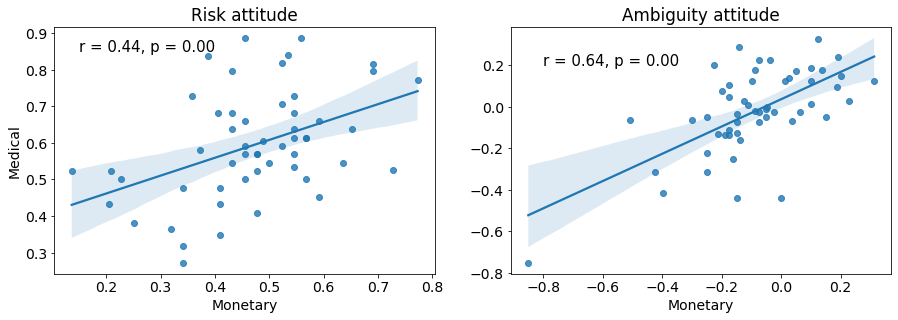

In [29]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize = (15,10))
#fig.suptitle('Correlation of Choice Behavior Between Domains', fontsize=16)

#fig.text(0.5, 0.45, 'Monetary', ha='center', fontsize=14)
#fig.text(0.04, 0.7, 'Medical', va='center', rotation='vertical', fontsize=14)

ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)    

sns.regplot(x='MontaryRisk',y='MedicalRisk',data=proportion, ax=ax1)
sns.regplot(x='MontaryAmb',y='MedicalAmb',data=proportion, ax=ax2)

ax1.set(xlabel='Monetary', ylabel='Medical', title='Risk attitude')
ax2.set(xlabel='Monetary', ylabel=None, title='Ambiguity attitude')

corr = (sp.stats.pearsonr(proportion.MontaryRisk, proportion.MedicalRisk))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax1.text(0.15, .85, text, fontsize=15)

corr = (sp.stats.pearsonr(proportion.MontaryAmb, proportion.MedicalAmb))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax2.text(-.8, .2, text, fontsize=15)

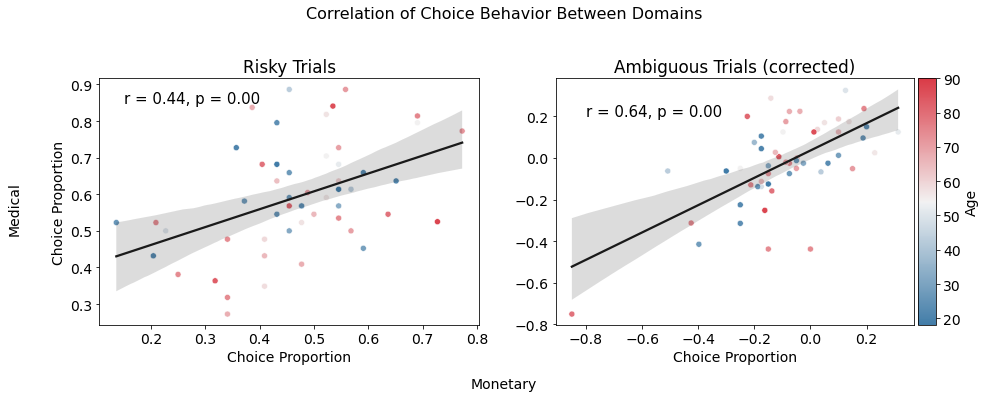

In [30]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize = (15,10))
fig.suptitle('Correlation of Choice Behavior Between Domains', fontsize=16)

fig.text(0.5, 0.45, 'Monetary', ha='center', fontsize=14)
fig.text(0.04, 0.7, 'Medical', va='center', rotation='vertical', fontsize=14)

ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)    

sns.scatterplot(x='MontaryRisk',y='MedicalRisk',data=proportion, ax=ax1, hue = 'age', palette = colors)
sns.scatterplot(x='MontaryAmb',y='MedicalAmb',data=proportion, ax=ax2, hue = 'age', palette = colors)

sns.regplot(x='MontaryRisk',y='MedicalRisk',data=proportion, ax=ax1, scatter=False, color=".1")
sns.regplot(x='MontaryAmb',y='MedicalAmb',data=proportion, ax=ax2, scatter=False, color=".1")


ax1.set(xlabel='Choice Proportion', ylabel='Choice Proportion', title='Risky Trials')
ax2.set(xlabel='Choice Proportion', ylabel=None, title='Ambiguous Trials (corrected)')

ax1.legend_.remove()
ax2.legend_.remove()

corr = (sp.stats.pearsonr(proportion.MontaryRisk, proportion.MedicalRisk))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax1.text(0.15, .85, text, fontsize=15)

corr = (sp.stats.pearsonr(proportion.MontaryAmb, proportion.MedicalAmb))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax2.text(-.8, .2, text, fontsize=15)

## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()


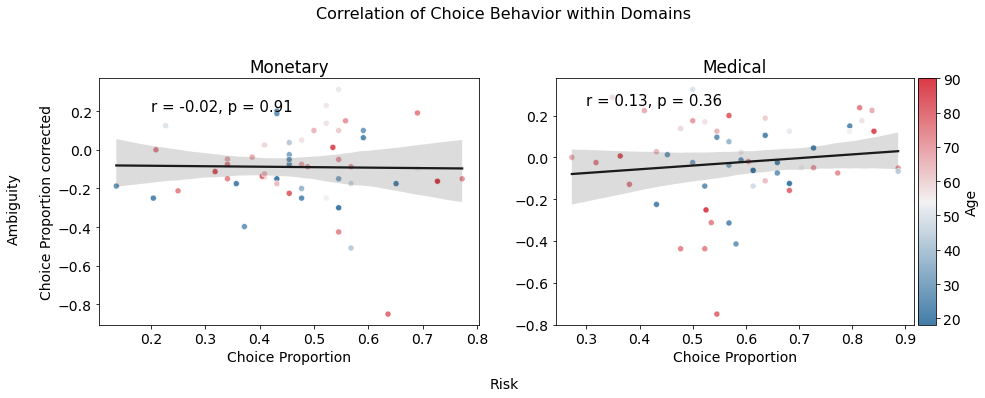

In [31]:
fig = plt.figure(figsize = (15,10))
fig.suptitle('Correlation of Choice Behavior within Domains', fontsize=16)

fig.text(0.5, 0.45, 'Risk', ha='center', fontsize=14)
fig.text(0.04, 0.7, 'Ambiguity', va='center', rotation='vertical', fontsize=14)

ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)

sns.scatterplot(x='MontaryRisk',y='MontaryAmb',data=proportion, ax=ax1, hue = 'age', palette = colors)
sns.scatterplot(x='MedicalRisk',y='MedicalAmb',data=proportion, ax=ax2, hue = 'age', palette = colors)


sns.regplot(x='MontaryRisk',y='MontaryAmb',data=proportion, ax=ax1, scatter=False, color=".1")
sns.regplot(x='MedicalRisk',y='MedicalAmb',data=proportion, ax=ax2, scatter=False, color=".1")


ax1.set(xlabel='Choice Proportion', ylabel='Choice Proportion corrected', title='Monetary')
ax2.set(xlabel='Choice Proportion', ylabel=None, title='Medical')

ax1.legend_.remove()
ax2.legend_.remove()

corr = (sp.stats.pearsonr(proportion.MontaryRisk, proportion.MontaryAmb))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax1.text(0.2, .2, text, fontsize=15)

corr = (sp.stats.pearsonr(proportion.MedicalRisk, proportion.MedicalAmb))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax2.text(.3, .25, text, fontsize=15)

## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()


Text(20, 0.2, 'r = -0.02, p = 0.88')

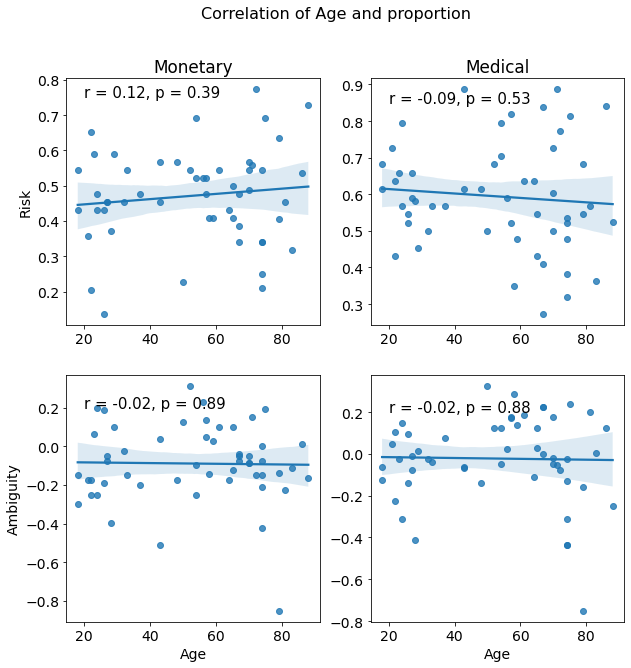

In [32]:
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(2,2, figsize=(10, 10))
f.suptitle('Correlation of Age and proportion', fontsize=16)

sns.regplot(x = 'age', y = 'MontaryRisk', data = proportion, ax=ax[0,0])
sns.regplot(x = 'age', y = 'MedicalRisk', data = proportion, ax=ax[0,1])
sns.regplot(x = 'age', y = 'MontaryAmb',  data = proportion, ax=ax[1,0])
sns.regplot(x = 'age', y = 'MedicalAmb',  data = proportion, ax=ax[1,1])


ax[0,0].set(xlabel=None, ylabel='Risk', title='Monetary')
ax[0,1].set(xlabel=None, ylabel=None, title='Medical')
ax[1,0].set(xlabel='Age', ylabel='Ambiguity')
ax[1,1].set(xlabel='Age', ylabel=None)

corr = (sp.stats.pearsonr(proportion.age, proportion.MontaryRisk))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0,0].text(20, .75, text, fontsize=15)

corr = (sp.stats.pearsonr(proportion.age, proportion.MedicalRisk))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0,1].text(20, .85, text, fontsize=15)

corr = (sp.stats.pearsonr(proportion.age, proportion.MontaryAmb))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1,0].text(20, .2, text, fontsize=15)

corr = (sp.stats.pearsonr(proportion.age, proportion.MedicalAmb))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1,1].text(20, .2, text, fontsize=15)

In [33]:
const = db_mon.groupby(['sub','age', 'risk', 'ambiguity', 'value']).sum()['choice'].reset_index()
const['score'] = np.where(const['choice']==4, 0, 
                          np.where(const['choice']==3, 1, 
                                   np.where(const['choice']==2, 2, const['choice'])))
const = const.groupby(['sub','age']).sum()['score'].reset_index()

const_med = db_med.groupby(['sub','age', 'risk', 'ambiguity', 'value']).sum()['choice'].reset_index()
const_med['score'] = np.where(const_med['choice']==4, 0, 
                          np.where(const_med['choice']==3, 1, 
                                   np.where(const_med['choice']==2, 2, const_med['choice'])))
const_med = const_med.groupby(['sub','age']).sum()['score'].reset_index()

Text(20, 20, 'r = 0.07, p = 0.59')

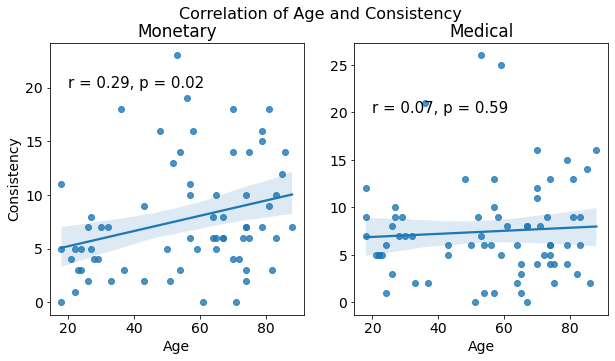

In [34]:
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(1,2, figsize=(10, 5))
f.suptitle('Correlation of Age and Consistency', fontsize=16)

sns.regplot(x = 'age', y = 'score', data = const, ax=ax[0])
sns.regplot(x = 'age', y = 'score', data = const_med, ax=ax[1])


ax[0].set(xlabel='Age', ylabel='Consistency', title='Monetary')
ax[1].set(xlabel='Age', ylabel=None, title='Medical')


corr = (sp.stats.pearsonr(const.age, const.score))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0].text(20, 20, text, fontsize=15)

corr = (sp.stats.pearsonr(const_med.age, const_med.score))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1].text(20, 20, text, fontsize=15)

In [35]:
const2 = db_mon[db_mon['moca_score']>25].groupby(['sub','age', 'risk', 'ambiguity', 'value']).sum()['choice'].reset_index()
const2['score'] = np.where(const2['choice']==4, 0, 
                          np.where(const2['choice']==3, 1, 
                                   np.where(const2['choice']==2, 2, const2['choice'])))
const2 = const2.groupby(['sub','age']).sum()['score'].reset_index()

const_med2 = db_med[db_med['moca_score']>25].groupby(['sub','age', 'risk', 'ambiguity', 'value']).sum()['choice'].reset_index()
const_med2['score'] = np.where(const_med2['choice']==4, 0, 
                          np.where(const_med2['choice']==3, 1, 
                                   np.where(const_med2['choice']==2, 2, const_med2['choice'])))
const_med2 = const_med2.groupby(['sub','age']).sum()['score'].reset_index()

Text(20, 20, 'r = 0.15, p = 0.27')

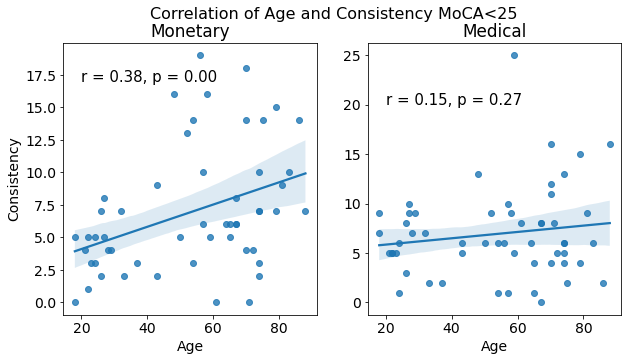

In [36]:
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(1,2, figsize=(10, 5))
f.suptitle('Correlation of Age and Consistency MoCA<25', fontsize=16)

sns.regplot(x = 'age', y = 'score', data = const2, ax=ax[0])
sns.regplot(x = 'age', y = 'score', data = const_med2, ax=ax[1])


ax[0].set(xlabel='Age', ylabel='Consistency', title='Monetary')
ax[1].set(xlabel='Age', ylabel=None, title='Medical')


corr = (sp.stats.pearsonr(const2.age, const2.score))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0].text(20, 17, text, fontsize=15)

corr = (sp.stats.pearsonr(const_med2.age, const_med2.score))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1].text(20, 20, text, fontsize=15)

In [36]:
proportion.to_csv('data/prop.csv')